In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
print(os.path.abspath(os.curdir))

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from scipy import signal as sg
# from sklearn.utils import shuffle

import rfcutils # this corresponds to utility functions provided for the challenge

from src import unet_model as unet
from src import cnn_model_delay as cnn_delay
from src.time_proc import long_window

get_sinr = lambda s, i: 10*np.log10(np.mean(np.abs(s)**2)/np.mean(np.abs(i)**2))
get_pow = lambda s: np.mean(np.abs(s)**2)

2022-08-17 11:10:29.762558: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


---

In [3]:
def eval_qpsk_demod(sig_est, sig_true, start_idx):
    qpsk_sig_idx = 16 - start_idx%16
    bit_est = rfcutils.matched_filter_demod(sig_est[qpsk_sig_idx:])
    bit_true = rfcutils.matched_filter_demod(sig_true[qpsk_sig_idx:])
    ber = np.sum(bit_est != bit_true)/len(bit_true)
    assert len(bit_est) == len(bit_true)
    return ber

def eval_sigs(sig_est, sig_true, start_idx):
    mse = get_pow(sig_est - sig_true)
    mse_db = 10*np.log10(mse)
    sdr = get_sinr(sig_true, sig_est-sig_true)
    ber = eval_qpsk_demod(sig_est, sig_true, start_idx)
    return (mse, mse_db, sdr, ber)

## Load models

In [4]:
seq_len = 10240
window_len = 10240
training_examples = 400
eff_train_ex = int(training_examples*seq_len/window_len)
seg_len = 0
long_k_sz = 101

In [5]:
print(f'Loading model qpsk_ofdm64_W{seq_len}_TS{eff_train_ex}_K{long_k_sz}')
nn_model = unet.get_unet_model_XL_2((window_len+seg_len, 2), k_sz=3, long_k_sz=long_k_sz, start_idx=seg_len//2, window_len=window_len)
nn_model.load_weights(f'trained_models/cond/checkpoint_qpsk_ofdm64_W{window_len}_TS{training_examples}_K{long_k_sz}')

Loading model qpsk_ofdm64_W10240_TS400_K101


2022-08-17 11:10:43.394161: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-17 11:10:43.395124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-17 11:10:43.538819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-17 11:10:43.538852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-17 11:10:43.543831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-17 11:10:43.543864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [6]:

print(f'Loading model qpsk_ofdm64_W{window_len}_TS{eff_train_ex}_K{long_k_sz}')
nn_model_cond = unet.get_unet_model_XL_2((window_len+seg_len, 2), k_sz=3, long_k_sz=long_k_sz, start_idx=seg_len//2, window_len=window_len)

Loading model qpsk_ofdm64_W10240_TS400_K101


## Generate signals and perform interference rejection

In [7]:
all_test_sig_mixture, all_test_sig1, all_test_sig2, all_test_sync_idx2, all_test_sig1_syms, all_test_sig1_bits, all_test_start_idx2 = pickle.load(open('dataset/Ex3C_TestSet_QPSK_OFDMQAM16.pickle','rb'))

In [8]:
mf_ber, nn_ber, nn_mse = [], [], []
nn_ber_cond, nn_mse_cond = [], []

all_sinr = np.arange(-30, 4, 1.5)
n_per_sinr_test = 100

for j in tqdm(np.arange(len(all_sinr))):
    for i in range(n_per_sinr_test):
        
        start_idx = all_test_sync_idx2[j*n_per_sinr_test + i]
        tau_b = (80 - start_idx%80)%80
        nn_model_cond.load_weights(f'trained_models/cond/checkpoint_qpsk_ofdm64_W{window_len}_TS{eff_train_ex}_K{long_k_sz}_S{start_idx}').expect_partial()
        
        all_sig1_ex = np.array(all_test_sig1[j*n_per_sinr_test + i])
        sig1 = all_sig1_ex[:seq_len]
        all_sig2_ex = np.array(all_test_sig2[j*n_per_sinr_test + i])
        sig2 = all_sig2_ex[:seq_len]
        all_sig_mixture_ex = np.array(all_test_sig_mixture[j*n_per_sinr_test + i])
        sig_mixture = all_sig_mixture_ex[:seq_len]

        mf_ber.append((eval_sigs(sig1, sig_mixture, 0))[-1])
        
        mixture_segT = long_window(sig_mixture.reshape(1,-1), window_len, seg_len)
        mixture_bands_compT = np.dstack((mixture_segT.real, mixture_segT.imag))
        
#         tau_b_est = np.argmax(synch_model(mixture_bands_compT[:,:window_len,:]))
     
        out1_est = nn_model(mixture_bands_compT).numpy()
        out1_est_cond = nn_model_cond(mixture_bands_compT).numpy()
        
        sig1_est = (out1_est[:,:,0] + 1j*out1_est[:,:,1]).flatten()
        sig1_est_cond = (out1_est_cond[:,:,0] + 1j*out1_est_cond[:,:,1]).flatten()
        
        nn_ber.append((eval_sigs(sig1_est, sig1, 0))[-1])
        nn_mse.append((eval_sigs(sig1_est, sig1, 0))[1])
        nn_ber_cond.append((eval_sigs(sig1_est_cond, sig1, 0))[-1])
        nn_mse_cond.append((eval_sigs(sig1_est_cond, sig1, 0))[1])
        
        


  0%|          | 0/23 [00:00<?, ?it/s]2022-08-17 11:10:47.367098: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-08-17 11:10:48.621152: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-17 11:10:48.746072: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-17 11:10:50.809564: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-17 11:10:51.181766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
100%|██████████| 23/23 [07:08<00:00, 18.64s/it]


(-24.0, 0.0)

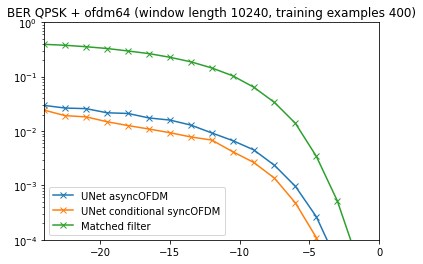

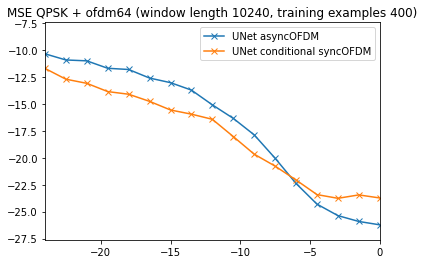

In [10]:
plt.figure()
nsim = n_per_sinr_test
plt.semilogy(all_sinr,np.array(nn_ber).reshape(-1,nsim).mean(axis=-1), 'x-', label='UNet asyncOFDM')
plt.plot(all_sinr,np.array(nn_ber_cond).reshape(-1,nsim).mean(axis=-1), 'x-', label='UNet conditional syncOFDM')

plt.semilogy(all_sinr,np.array(mf_ber).reshape(-1,nsim).mean(axis=-1), 'x-', label='Matched filter')

plt.legend()
plt.title(f'BER QPSK + ofdm64 (window length {window_len}, training examples {eff_train_ex})')
plt.xlim(xmax = 0, xmin = -24)
plt.ylim(ymax = 1, ymin = 1e-4)
# plt.savefig(f'qpsk_ofdm64_ber_sync_nopad_train_{window_len}_TS_{training_examples}_cond_1.pdf')



plt.figure()
SIR_values = np.arange(-24, 1.5, 1.5)
plt.plot(all_sinr,np.array(nn_mse).reshape(-1,nsim).mean(axis=-1), 'x-', label='UNet asyncOFDM')
plt.plot(all_sinr,np.array(nn_mse_cond).reshape(-1,nsim).mean(axis=-1), 'x-', label='UNet conditional syncOFDM')

plt.legend()
plt.title(f'MSE QPSK + ofdm64 (window length {window_len}, training examples {eff_train_ex})')
plt.xlim(xmax = 0, xmin = -24)
# plt.ylim(ymax = 1, ymin = 1e-5)
# plt.savefig(f'qpsk_ofdm64_mse_sync_nopad_train_{window_len}_TS_{training_examples}_cond_1.pdf')

In [14]:
# Save BER
nn_ber_async_data = np.stack((all_sinr,np.array(nn_ber).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/ber_nn_async_{window_len}.csv', nn_ber_async_data, delimiter=",")

nn_ber_cond_data = np.stack((all_sinr,np.array(nn_ber_cond).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/ber_nn_sync_{window_len}.csv', nn_ber_cond_data, delimiter=",")

# Save MSE:
nn_mse_async_data = np.stack((all_sinr,np.array(nn_mse).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/mse_nn_async_{window_len}.csv', nn_mse_async_data, delimiter=",")

nn_mse_cond_data = np.stack((all_sinr,np.array(nn_mse_cond).reshape(-1,nsim).mean(axis=-1)),axis=1)
np.savetxt(f'data/mse_nn_sync_{window_len}.csv', nn_mse_cond_data, delimiter=",")


In [17]:
t = 3
m2 = t * np.std(np.array(nn_ber).reshape(-1,nsim), axis=1, ddof=1) / np.sqrt(100)
m1 = t * np.std(np.array(nn_ber_cond).reshape(-1,nsim), axis=1, ddof=1) / np.sqrt(100)

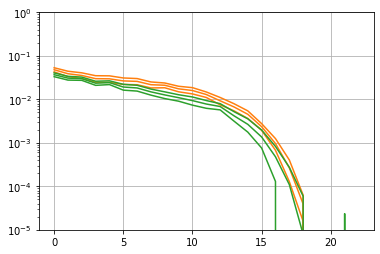

In [18]:
plt.semilogy(np.mean(np.array(nn_ber).reshape(-1,nsim), axis=1) + m1, color='tab:orange')
plt.plot(np.mean(np.array(nn_ber).reshape(-1,nsim), axis=1), color='tab:orange')
plt.plot(np.mean(np.array(nn_ber).reshape(-1,nsim), axis=1) - m1, color='tab:orange')
plt.plot(np.mean(np.array(nn_ber_cond).reshape(-1,nsim), axis=1) - m2, color='tab:green')
plt.plot(np.mean(np.array(nn_ber_cond).reshape(-1,nsim), axis=1), color='tab:green')
plt.plot(np.mean(np.array(nn_ber_cond).reshape(-1,nsim), axis=1) + m2, color='tab:green')

plt.ylim([1e-5, 1])
plt.grid()